In [1]:
# Imports 
import numpy as np
import pandas as pd
import pyodbc as db
import matplotlib.pyplot as plt
import os
%matplotlib inline
import requests
from requests.auth import HTTPBasicAuth
from io import StringIO
from sodapy import Socrata
from datetime import date
import datetime
import seaborn as sns

# Constants 
stringVAERSDATA     = "VAERSDATA"
stringVAERSSYMPTOMS = "VAERSSYMPTOMS"
stringVAERSVAX      = "VAERSVAX"

# API values 
# https://dev.socrata.com/foundry/data.cdc.gov/unsk-b7fc
# https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-Jurisdi/unsk-b7fc
# https://dev.socrata.com/foundry/data.cdc.gov/unsk-b7fc
apiKeyName      = "IAN_VAERS"
apiKeyId        = "b4nhr0ojmr7cq4envv3a8ofc5"
apiSecretApi    = "3ry6vfrzt53fl7p0kn8ir8hdnq70aeclapu5abnar08r8fbz5d"
apiToken        = "jDHbO06h1r193Y7NHHlbNWVfW"
apiSecretToken  = "9BZJSPTkndWKvJWBZp-mVIHK8X3yVrk9gBND"

# Column datatypes - need to finish @TODO - getting the following warning when reading in files:
# DtypeWarning: Columns (11,13,15,16,27) have mixed types.Specify dtype option on import or set low_memory=False. interactivity=interactivity, compiler=compiler, result=result)
dtype_VAERSDATA = {"VAERS_ID": np.int64, "RECVDATE": np.object, "STATE": np.str, "AGE_YRS": np.float64, "CAGE_YR": np.float64, "CAGE_MO": np.float64, "SEX": np.str, "RPT_VDATE": np.object, "SYMPTOM_TEXT": np.str, "DIED": np.str, "DATEDIED": np.object, "L_THREAD": np.str, "ER_VISIT": np.str}

In [ ]:
# Return age bucket for age passed in 
def ageRangeFromAge(inAge):

    # Check ranges 
    if(inAge >= 100):
        return "GTE_100"
    elif(inAge >= 90):
        return "90_99"
    elif(inAge >= 80):
        return "80_89"
    elif(inAge >= 70):
        return "70_79"
    elif(inAge >= 60):
        return "60_69"
    elif(inAge >= 50):
        return "50_59"

In [2]:
# Locals 
dfVAERSDATA_Initialized     = False
dfVAERSSYMPTOMS_Initialized = False
dfVAERSVAX_Initialized      = False
directory = '.\AllVAERSDataCSVS'
 
# Iterate over files 
for filename in os.listdir(directory):

    # Create the file name 
    fullFilename = os.path.join(directory, filename)

    # Ensure its a file
    if os.path.isfile(fullFilename):

        # Print the file name to see where it breaks - if needed 
        # print(fullFilename)

        # Overall
        if(fullFilename.__contains__(stringVAERSDATA)):
            
            # Check if the dataframe has been initialized
            if(dfVAERSDATA_Initialized == False):
                
                # Read in the file to this dataframe directly 
                dfVAERSDATA = pd.read_csv(fullFilename, encoding='cp1252', dtype=dtype_VAERSDATA)

                # Set to init 
                dfVAERSDATA_Initialized = True

            else:

                # Add the new file to the dataframe that has been init'd
                dfVAERSDATA = pd.concat([dfVAERSDATA, pd.read_csv(fullFilename, encoding='cp1252', dtype=dtype_VAERSDATA)], ignore_index=True)
            
        # Symptoms
        elif(fullFilename.__contains__(stringVAERSSYMPTOMS)):
            
            # Check if the dataframe has been initialized
            if(dfVAERSSYMPTOMS_Initialized == False):
                
                # Read in the file to this dataframe directly 
                dfVAERSSYMPTOMS = pd.read_csv(fullFilename, encoding='cp1252')

                # Set to init 
                dfVAERSSYMPTOMS_Initialized = True

            else:

                # Add the new file to the dataframe that has been init'd
                dfVAERSSYMPTOMS = pd.concat([dfVAERSSYMPTOMS, pd.read_csv(fullFilename, encoding='cp1252')], ignore_index=True)

        # Vax
        elif(fullFilename.__contains__(stringVAERSVAX)):
            
            # Check if the dataframe has been initialized
            if(dfVAERSVAX_Initialized == False):
                
                # Read in the file to this dataframe directly 
                dfVAERSVAX = pd.read_csv(fullFilename, encoding='cp1252')

                # Set to init 
                dfVAERSVAX_Initialized = True

            else:

                # Add the new file to the dataframe that has been init'd
                dfVAERSVAX = pd.concat([dfVAERSVAX, pd.read_csv(fullFilename, encoding='cp1252')], ignore_index=True)
        

# Merge the vax with the symptoms tables have duplicates or can 
# have duplicates hence using full outer join. Merging vax and symptoms first.
completeDataFrame = pd.merge(left = dfVAERSVAX, right = dfVAERSSYMPTOMS, \
                      how = "outer", left_on = ["VAERS_ID"], \
                      right_on = ["VAERS_ID"])

# Now merge the data frame into the merged frame 
completeDataFrame = pd.merge(left = completeDataFrame, right = dfVAERSDATA, \
                      how = "outer", left_on = ["VAERS_ID"], \
                      right_on = ["VAERS_ID"])

# Make a copy so we can leave the original untouched 
workingVaxFrame = completeDataFrame.copy(deep=True)

# Print the frame out for fun - DO NOT DO THIS CAUSE THE FILE IS WAY TOO BIG 
# workingVaxFrame.to_csv("workingVaxFrame.csv")

# Performance notes:
# Takes about 100 seconds on Dell Precision 752 with Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, 2701 Mhz, 4 Core(s), 8 Logical Processor(s)

D:\ProgramFiles\Python\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (11,13,15,16,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
D:\ProgramFiles\Python\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
D:\ProgramFiles\Python\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (7,15,23,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
D:\ProgramFiles\Python\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (7,15,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=inte

In [11]:
# Taken directly from 
# https://dev.socrata.com/foundry/data.cdc.gov/unsk-b7fc

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cdc.gov", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cdc.gov,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 50000 results, returned as JSON from API / converted to Python list of dictionaries by sodapy.
getResults = client.get("unsk-b7fc", limit=50000)

# Convert to pandas DataFrame
administrationDataFrame = pd.DataFrame.from_records(getResults)

# Convert to date time 
administrationDataFrame["date"] = pd.to_datetime(administrationDataFrame["date"]).dt.date

# Print to file 
administrationDataFrame.to_csv("administrationDataFrame.csv")

# Alternative method - may be useful later 
# rawResponse = requests.get('https://data.cdc.gov/resource/unsk-b7fc.csv', auth=HTTPBasicAuth(apiKeyId, apiSecretApi))
# stringResponse = StringIO(rawResponse.text)
# vaxAdministeredDataFrame = pd.read_csv(stringResponse, sep =",")
# vaxAdministeredDataFrame.to_csv("vaxAdministeredDataFrame.csv")

# Make a copy so we can leave the original untouched 
workingAdministrationDataFrame = administrationDataFrame.copy(deep=True)

# Only return the latest date 
todaysAdministered = workingAdministrationDataFrame[workingAdministrationDataFrame.date == workingAdministrationDataFrame.date.max()]

# Check data is present 
todaysAdministered.shape

(65, 81)

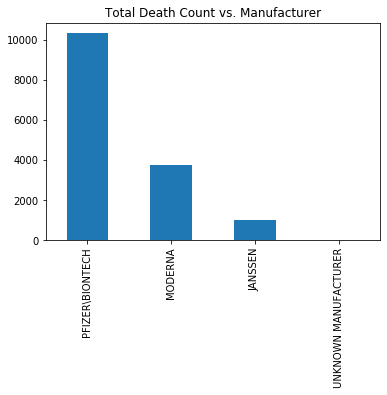

In [12]:
# Get all the values of the type of vaccine to try and find the covid 
covidFrame = workingVaxFrame[workingVaxFrame["VAX_TYPE"] == "COVID19"]

# Get all the deaths per manufacturer
covidDeathsFramePerMfg = (covidFrame[covidFrame["DIED"] == "Y"].drop_duplicates(subset=["VAERS_ID"]))["VAX_MANU"].value_counts().to_frame()

# Convert to a float 
covidDeathsFramePerMfg["VAX_MANU"] = covidDeathsFramePerMfg["VAX_MANU"].astype("float")

# INDEX	                    VAX_MANU
# PFIZER\BIONTECH	        10319
# MODERNA	                3763
# JANSSEN	                1021
# UNKNOWN MANUFACTURER	    41

# Show graphs of deaths per million for each mfg 
covidDeathsFramePerMfg["VAX_MANU"].plot(kind = "bar", title = "Total Death Count vs. Manufacturer")

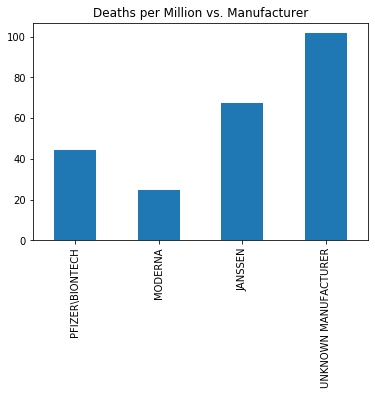

In [13]:
# Get todays date for us only 
usAdministered = todaysAdministered[todaysAdministered.location == "US"]

# Make a copy of the deaths frame 
localCovidDeathsFramePerMfg = covidDeathsFramePerMfg.copy(deep = True)

# Percent deaths 
localCovidDeathsFramePerMfg.loc["PFIZER\BIONTECH"].VAX_MANU          = (float)((float)(localCovidDeathsFramePerMfg.loc["PFIZER\BIONTECH"].VAX_MANU) / (float)(usAdministered["administered_pfizer"])) * 1000000.0
localCovidDeathsFramePerMfg.loc["MODERNA"].VAX_MANU                  = (float)((float)(localCovidDeathsFramePerMfg.loc["MODERNA"].VAX_MANU) / (float)(usAdministered["administered_moderna"])) * 1000000.0
localCovidDeathsFramePerMfg.loc["JANSSEN"].VAX_MANU                  = (float)((float)(localCovidDeathsFramePerMfg.loc["JANSSEN"].VAX_MANU) / (float)(usAdministered["administered_janssen"])) * 1000000.0
localCovidDeathsFramePerMfg.loc["UNKNOWN MANUFACTURER"].VAX_MANU     = (float)((float)(localCovidDeathsFramePerMfg.loc["UNKNOWN MANUFACTURER"].VAX_MANU) / (float)(usAdministered["administered_unk_manuf"])) * 1000000.0

# Show graphs of deaths per million for each mfg 
localCovidDeathsFramePerMfg["VAX_MANU"].plot(kind = "bar", title = "Deaths per Million vs. Manufacturer")

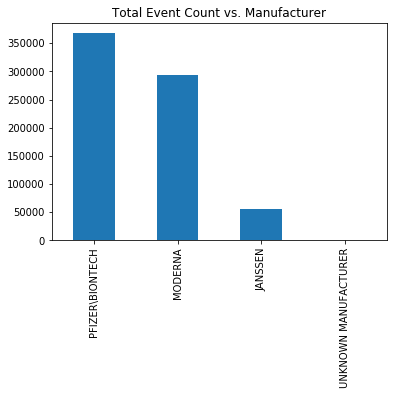

In [14]:
# Get all the events per manufacturer
covidEventsFramePerMfg = (covidFrame.drop_duplicates(subset=["VAERS_ID"]))["VAX_MANU"].value_counts().to_frame()

# Convert to a float 
covidEventsFramePerMfg["VAX_MANU"] = covidEventsFramePerMfg["VAX_MANU"].astype("float")

# INDEX	                    VAX_MANU
# PFIZER\BIONTECH	        10319
# MODERNA	                3763
# JANSSEN	                1021
# UNKNOWN MANUFACTURER	    41

# Show graphs of deaths per million for each mfg 
covidEventsFramePerMfg["VAX_MANU"].plot(kind = "bar", title = "Total Event Count vs. Manufacturer")

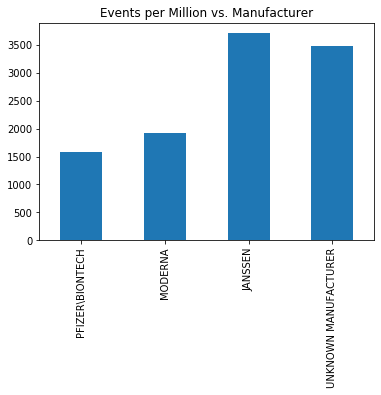

In [15]:
# Make a copy of the deaths frame 
localCovidEventsFramePerMfg = covidEventsFramePerMfg.copy(deep = True)

# Percent deaths 
localCovidEventsFramePerMfg.loc["PFIZER\BIONTECH"].VAX_MANU          = (float)((float)(localCovidEventsFramePerMfg.loc["PFIZER\BIONTECH"].VAX_MANU) / (float)(usAdministered["administered_pfizer"])) * 1000000.0
localCovidEventsFramePerMfg.loc["MODERNA"].VAX_MANU                  = (float)((float)(localCovidEventsFramePerMfg.loc["MODERNA"].VAX_MANU) / (float)(usAdministered["administered_moderna"])) * 1000000.0
localCovidEventsFramePerMfg.loc["JANSSEN"].VAX_MANU                  = (float)((float)(localCovidEventsFramePerMfg.loc["JANSSEN"].VAX_MANU) / (float)(usAdministered["administered_janssen"])) * 1000000.0
localCovidEventsFramePerMfg.loc["UNKNOWN MANUFACTURER"].VAX_MANU     = (float)((float)(localCovidEventsFramePerMfg.loc["UNKNOWN MANUFACTURER"].VAX_MANU) / (float)(usAdministered["administered_unk_manuf"])) * 1000000.0

# Show graphs of deaths per million for each mfg 
localCovidEventsFramePerMfg["VAX_MANU"].plot(kind = "bar", title = "Events per Million vs. Manufacturer")

BELOW THIS LINE IS ALL DEVELOPMENTAL 

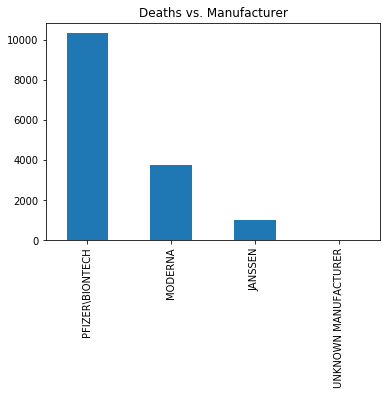

In [5]:
# Get all the deaths 
covidDeathsFrame = covidFrame[covidFrame["DIED"] == "Y"]

# Drop the duplicates which result for multiple vax at same time
covidDeathsFrameNoDupes = covidDeathsFrame.drop_duplicates(subset=["VAERS_ID"])

# Print the data to file 
covidDeathsFrameNoDupes.to_csv("covidDeathsFrameNoDupes.csv")

# Show the bar graph of deaths by manufacturer
covidDeathsFrameNoDupes["VAX_MANU"].value_counts().plot(kind = "bar", title = "Deaths vs. Manufacturer")

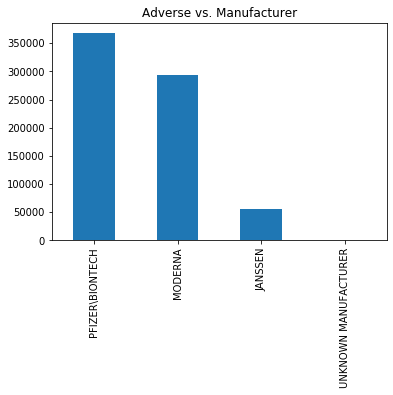

In [21]:
# Drop the duplicates which result for multiple vax at same time
covidFrameNoDupes = covidFrame.drop_duplicates(subset=["VAERS_ID"])

# Plot all the reactions by manufacturer
covidFrameNoDupes["VAX_MANU"].value_counts().plot(kind = "bar", title = "Adverse vs. Manufacturer")

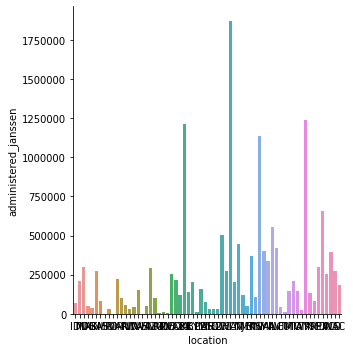

In [136]:
# Administered_Janssen	Administered_Moderna	Administered_Pfizer	Administered_Unk_Manuf

# Only return todays date 
todaysDataOnly = workingAdministrationDataFrame[workingAdministrationDataFrame.date == date.today()]
todaysDataOnly = todaysDataOnly[todaysDataOnly.location != "US"]


sns.catplot(x = "location",       # x variable name
            y = "administered_janssen",       # y variable name
            data = todaysDataOnly,     # dataframe to plot
            kind = "bar")



# todaysDataOnly["administered_janssen"]
# todaysDataOnly["administered_janssen"].plot(kind = "bar", index= title = "Adverse vs. Manufacturer")